## Importing libraries

In [1]:
!pip install torch torchmetrics torchaudio datasets transformers scikit-learn matplotlib wandb torchcodec

from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
)
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from google.colab import drive
import os
from google.colab import userdata
import torch
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.8 MB/s eta 0:00:00


## Getting paths for metadata and getting a key for wandb

In [2]:
BASE_DIR = '/content/'

TEST_PATH  = os.path.join(BASE_DIR, 'test.csv')

wandb_kay = userdata.get('WANDB')

## Log in to wandb

In [3]:
wandb.login(key=wandb_kay)

wandb.init(
    project="AST",
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: boklahbohdan (detect_kaggle) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Cloning your google drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Selecting the target directory

In [5]:
!rsync -a "/content/drive/MyDrive/audio_cls/" .

## Downloading a dataset

In [22]:
dataset = load_dataset(
    "csv",
    data_files={
        "test" : TEST_PATH
    }
)
dataset

DatasetDict({
    test: Dataset({
        features: ['path', 'target'],
        num_rows: 105
    })
})

In [23]:
LABELS = ['siren', 'gunshot', 'explosion', 'casual']
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for i, label in enumerate(LABELS)}

## Fix paths for a google colab

In [24]:
DATA_DIR_TRAIN = "/content/train"
DATA_DIR_VALID = "/content/valid"
DATA_DIR_TEST  = "/content/test"

def fix_path_test(example):
    example["path"] = f"{DATA_DIR_TEST}/{example["path"]}"
    return example

def fix_label(example):
    example["labels"] = example.pop("target")
    return example

test_df  = dataset['test']
test_df  = test_df.map(fix_path_test)
test_df  = test_df.map(fix_label)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Initial model

In [25]:
MODEL_NAME = "MIT/ast-finetuned-audioset-10-10-0.4593"

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModelForAudioClassification.from_pretrained(MODEL_NAME)

model.eval()

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

## Mapping

In [26]:
print("Model id2label:", model.config.id2label)

label_map = {
    'siren': 396,
    'gunshot': 427,
    'explosion': 426
}


Model id2label: {0: 'Speech', 1: 'Male speech, man speaking', 2: 'Female speech, woman speaking', 3: 'Child speech, kid speaking', 4: 'Conversation', 5: 'Narration, monologue', 6: 'Babbling', 7: 'Speech synthesizer', 8: 'Shout', 9: 'Bellow', 10: 'Whoop', 11: 'Yell', 12: 'Battle cry', 13: 'Children shouting', 14: 'Screaming', 15: 'Whispering', 16: 'Laughter', 17: 'Baby laughter', 18: 'Giggle', 19: 'Snicker', 20: 'Belly laugh', 21: 'Chuckle, chortle', 22: 'Crying, sobbing', 23: 'Baby cry, infant cry', 24: 'Whimper', 25: 'Wail, moan', 26: 'Sigh', 27: 'Singing', 28: 'Choir', 29: 'Yodeling', 30: 'Chant', 31: 'Mantra', 32: 'Male singing', 33: 'Female singing', 34: 'Child singing', 35: 'Synthetic singing', 36: 'Rapping', 37: 'Humming', 38: 'Groan', 39: 'Grunt', 40: 'Whistling', 41: 'Breathing', 42: 'Wheeze', 43: 'Snoring', 44: 'Gasp', 45: 'Pant', 46: 'Snort', 47: 'Cough', 48: 'Throat clearing', 49: 'Sneeze', 50: 'Sniff', 51: 'Run', 52: 'Shuffle', 53: 'Walk, footsteps', 54: 'Chewing, masticati

## Downloading audio samples

In [27]:
def preprocess(batch):
    waveform, sr = librosa.load(batch["path"], sr=16000)
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt"
    )
    batch["input_values"] = inputs["input_values"].squeeze(0).tolist()
    return batch

test_df  = test_df.map(preprocess)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Inference

In [28]:
y_true = []
y_pred = []

for row in tqdm(test_df, desc="Inference"):
    x = torch.tensor(row["input_values"]).unsqueeze(0)

    with torch.no_grad():
        logits = model(x).logits
        pred_idx = torch.argmax(logits, dim=-1).item()

    if pred_idx == label_map['siren']:
        final_pred = 0
    elif pred_idx == label_map['gunshot']:
        final_pred = 1
    elif pred_idx == label_map['explosion']:
        final_pred = 2
    else:
        final_pred = 3

    y_true.append(row["labels"])
    y_pred.append(final_pred)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average="macro"))
print("Precision macro:", precision_score(y_true, y_pred, average="macro"))
print("Recall macro:", recall_score(y_true, y_pred, average="macro"))

Inference: 100%|██████████| 105/105 [05:01<00:00,  2.87s/it]

Accuracy: 0.7142857142857143
F1 macro: 0.628210498409332
Precision macro: 0.854348826507133
Recall macro: 0.6247217222432739


## Make confusion matrix

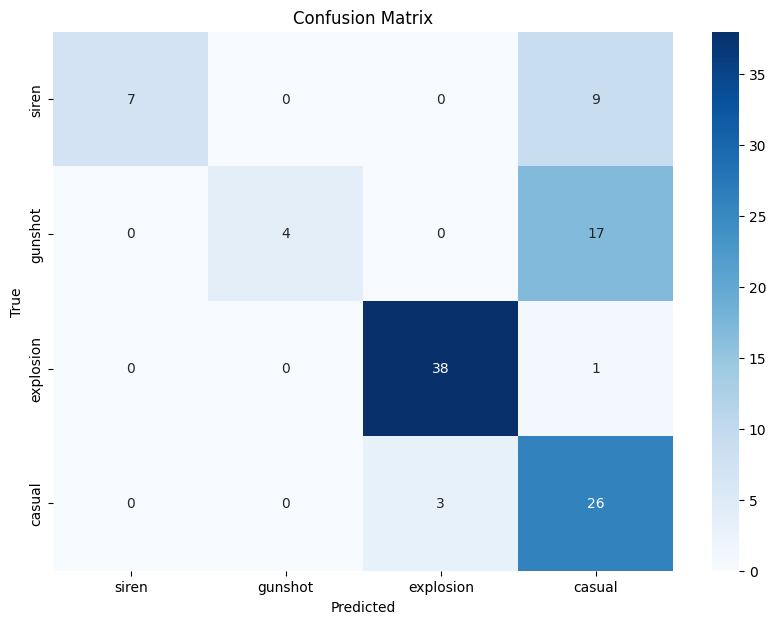

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()